<a href="https://colab.research.google.com/github/4nchez/Colab-Jupiter/blob/master/%EC%97%B0%EA%B5%AC%EC%8B%A4_%EA%B8%B0%EB%B3%B8%EC%BD%94%EB%93%9C.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Kaggle Challenge : Dogs-vs-Cats - Binary Image Classification using Keras
해당 포스트는 [Kaggle  Dogs-vs-Cats challenge](https://www.kaggle.com/c/dogs-vs-cats) 해결하기위해 만들었으며, 여러 가지 자료들을 참고하여 만든 포스트 입니다. [이분을 많이 참조..](https://github.com/mjbhobe/dl-articles-medium)


*   개발 환경 : google colab, Python3, Tensorflow, Keras
*   실험 모델 : 자체 제작 CNN, VGG16(Transfer Learning)
*   실험 순서 : 자체 제작 CNN -> Image Augmentation을 사용한 CNN -> pre traing VGG16 -> fine tuning VGG16
*   실험에 쓰인 데이터 : Kaggle Dogs vs Cats challenge
*   Test {개: 1,000, 고양이: 1,000} (총 2,000개)
*   Training {개: 5,000, 고양이: 5,000} (총 10,000개)
*   Validation {개: 2,500, 고양이: 2,500} (총 5,000개)
*   IMAGE_HEIGHT, IMAGE_WIDTH, NUM_CHANNELS, BATCH_SIZE = 150, 150, 3, 32

**결론** : **직접 모델을 생성하여 정확도를 높이는 것도 좋지만, 기존에 있는 좋은 모델을 가지고 fine tuning 하여 학습하는 방법이 더 효과가 좋을 수 있다.**

참고 사항
* Google Colab에서이 노트북을 실행할 때 아래 셀에`USE_COLAB = True`를 설정하고 그렇지 않으면`USE_COLAB = False`를 설정하세요.
*`USE_COLAB = True`는 현재 사용자의 로그인을 위해 Google 드라이브에 대한 액세스를 설정합니다 (Google ID가 있다고 가정).
    * Google 드라이브는 '/ content / drive / 내 드라이브'에 매핑되고 노트북은 Google 드라이브의 '/ content / drive / My Drive / Colab Notebooks /'폴더에 저장됩니다.
    * 코드는`/ content / drive / My Drive / Colab Notebooks /`폴더를`system.path`에 추가합니다. 커스텀 Python 코드 파일`(* .py)`를 여기에 저장하면`system.path`에 자동으로 추가되고 노트북에서 사용할 수 있습니다. *
*`MODEL_STATES` 전역 변수는 모델의 상태 (즉, 훈련 된 가중치 및 편향)가`.h5` 파일에 저장되는 _correct_ 폴더를 가리 키도록 생성됩니다.
    *`USE_COLAB = True` 인 경우`MODEL_STATES`는 Google Drive의`/ content / drive / My Drive / Colab Notebooks / model_states` 폴더에 매핑됩니다.
    * 그렇지 않으면`MODEL_STATES`는 로컬 디스크의`. / model_states` 폴더 (예 : 노트북이 저장된 폴더의 하위 폴더)에 매핑됩니다.

In [ ]:
from google.colab import files
src = list(files.upload().values())[0]

Saving kr_helper_funcs.py to kr_helper_funcs.py


구글 드라이브 연동 코드

In [ ]:
USE_COLAB = True
 
import os
 
#@see: https://colab.research.google.com/drive/1srw_HFWQ2SMgmWIawucXfusGzrj1_U0q
if USE_COLAB:
    from google.colab import drive
 
    gdrive_mount_point = '/content/drive/'
    drive.mount(gdrive_mount_point)
    grive_path = os.path.join(gdrive_mount_point, "My Drive/")
    print('Your Google Drive is mounted at ', grive_path)
    colab_notebooks_path = os.path.join(grive_path, "Colab Notebooks/")
    
    if os.path.exists(colab_notebooks_path):
        print('You Colab notebooks are available at ', colab_notebooks_path)
    
        #!ls '/content/drive/My Drive/Colab Notebooks/'
 
        import sys
        #sys.path.append("/content/drive/My Drive/Colab Notebooks/")
        sys.path.append(colab_notebooks_path)
        print('NOTE: {} is appended to sys.path!'.format(colab_notebooks_path))
        # import kr_helper_funcs as kru
        MODEL_SAVE_DIR = "/content/drive/My Drive/Colab Notebooks/model_states" #실험에 쓴 모델을 저장할 드라이브 경로
        IMAGES_ZIP_DIR = "/content/drive/My Drive/Colab Notebooks/data/cats_vs_dogs" #구글 드라이브에 저장되어 있는 데이터셋
    else:
        raise IOError("Unable to mount Google Drive!")
else:
    MODEL_SAVE_DIR = os.path.join('.','model_states')
    IMAGES_ZIP_DIR = "./images/kaggle/cats_vs_dogs"
    
if not os.path.exists(MODEL_SAVE_DIR):
    os.mkdir(MODEL_SAVE_DIR)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive/
Your Google Drive is mounted at  /content/drive/My Drive/
You Colab notebooks are available at  /content/drive/My Drive/Colab Notebooks/
NOTE: /content/drive/My Drive/Colab Notebooks/ is appended to sys.path!


## Kaggle  Dogs-vs-Cats challenge Dataset
Kaggle train.zip 에는 개와 고양이의 이미지 25,000 개 (고양이 색상 이미지 12,500 개 및 다양한 크기의 개 색상 이미지 12,500 개)가 포함되어 있습니다.

train Data 중 별도의 프로그램을 사용하여 고양이와 개에 개에 각각 5,000개의 훈련 이미지, 고양이와 개에 대한 2,500개의 평가 이미지, 고양이와 개에 개에 각각 1,000개의 테스트 이미지로 구성된 작은 데이터 세트를 만들었습니다. 그런 다음 이미지 Dataset.zip 파일을 Google 드라이브에 업로드했습니다.

zip 파일 cats_vs_dogs_images_small.zip은 내 Google 드라이브의 IMAGES_ZIP_DIR에서 사용할 수 있습니다. 아래 코드 셀은 로컬로 다운로드하고 /tmp 폴더에 이미지 압축을 풉니다.

In [ ]:
import sys, os, random
import numpy as np
import tensorflow as tf
print('Using Tensorflow version ', tf.__version__)
import matplotlib.pyplot as plt
%matplotlib inline
 
import kr_helper_funcs as kru
 
plt.style.use('seaborn')
 
seed = 123
random.seed(seed)
np.random.seed(seed)
# tf.set_random_seed(seed)
 
import warnings
warnings.filterwarnings('ignore')  # ignore all warnings

Using Tensorflow version  2.3.0


In [ ]:
import os, shutil
import zipfile
 
#!cp $(IMAGES_ZIP_DIR/images_small.zip" /tmp
source_file = os.path.join(IMAGES_ZIP_DIR, 'cats_vs_dogs_images_small.zip')
local_zip = '/tmp/cats_vs_dogs_images_small.zip'
 
print("Copying from drive %s to %s..." % (source_file, local_zip), flush=True)
shutil.copyfile(source_file, local_zip)
 
assert os.path.exists(local_zip)
 
print('Extracting all images...', flush=True)
zip_ref = zipfile.ZipFile(local_zip, 'r')
 
zip_ref.extractall('/tmp')
zip_ref.close()

Copying from drive /content/drive/My Drive/Colab Notebooks/data/cats_vs_dogs/cats_vs_dogs_images_small.zip to /tmp/cats_vs_dogs_images_small.zip...
Extracting all images...


## 실험에 쓰일 데이터 파일 연결

In [ ]:
images_root = "/tmp" # /content/drive/My Drive/img
assert os.path.exists(images_root), "%s folder does not exist!" % images_root
 
train_root = os.path.join(images_root,'training')
train_root_cat = os.path.join(train_root,'cat')
train_root_dog = os.path.join(train_root,'dog')
 
eval_root = os.path.join(images_root,'validation')
eval_root_cat = os.path.join(eval_root,'cat')
eval_root_dog = os.path.join(eval_root,'dog')
 
test_root = os.path.join(images_root,'test')
test_root_cat = os.path.join(test_root,'cat')
test_root_dog = os.path.join(test_root,'dog')

In [ ]:
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Input, Conv2D, BatchNormalization, MaxPooling2D, 
                                     Flatten, Dense, Dropout)
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import kr_helper_funcs as kru

In [ ]:
IMAGE_HEIGHT, IMAGE_WIDTH, NUM_CHANNELS, BATCH_SIZE = 150, 150, 3, 32

### pre-trained model VGG16

pre-trained 된 VGG16 모델을 사용합니다. VGG16모델의 끝부분인 FC 부분은 자르고 challenge에 맞게 다시 설정했습니다.


In [ ]:
from tensorflow.keras.applications import VGG16
 
# NOTE: will download the weights for imagenet
vgg_base = VGG16(weights='imagenet',    # ImageNet 가중치 사용
                 include_top=False,     # Dense layers 사용 안함
                 input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, NUM_CHANNELS))
print(vgg_base.summary())

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

In [ ]:
def build_model_xfer():
    from tensorflow.keras.optimizers import Adam
    
    #tf.keras.backend.clear_session()  # reset graph etc.
    
    model = tf.keras.models.Sequential([
        vgg_base,
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dropout(0.50),
        tf.keras.layers.Dense(1024, activation='relu'),
        tf.keras.layers.Dropout(0.20),        
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.Dropout(0.10),         
        tf.keras.layers.Dense(1, activation='sigmoid')    
    ])
    
    vgg_base.trainable = False
    
    model.compile(optimizer=Adam(lr=1e-4), 
                  loss='binary_crossentropy',
                  metrics=['acc'])
    return model

In [ ]:
model_xfer = build_model_xfer()
print(model_xfer.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 8192)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 1024)              8389632   
_________________________________________________________________
dropout_6 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 512)               524800    
_________________________________________________________________
dropout_7 (Dropout)          (None, 512)               0

**그리하여 총 23,629,633개의 파라미터를 가진 모델을 생성했습니다. 그러나 그중 학습후 가중치가 갱신되는 파라미터는 8,914,945(직접만든 FC)입니다. 컨볼루션층은 기존의 학습된 가중치를 사용합니다.**

In [ ]:
train_datagen = ImageDataGenerator(rescale=1.0/255)
eval_datagen = ImageDataGenerator(rescale=1.0/255)
test_datagen = ImageDataGenerator(rescale=1.0/255)
 
train_generator = train_datagen.flow_from_directory(
    train_root,
    target_size=(IMAGE_HEIGHT,IMAGE_WIDTH),  # 이미지 사이즈 변경
    batch_size=BATCH_SIZE,
    class_mode='binary')
 
eval_generator = eval_datagen.flow_from_directory(
    eval_root,
    target_size=(IMAGE_HEIGHT,IMAGE_WIDTH),  # 이미지 사이즈 변경
    batch_size=BATCH_SIZE,
    class_mode='binary')
 
test_generator = test_datagen.flow_from_directory(
    test_root,
    target_size=(IMAGE_HEIGHT,IMAGE_WIDTH),  # 이미지 사이즈 변경
    batch_size=BATCH_SIZE,
    class_mode='binary')

Found 10000 images belonging to 2 classes.
Found 5000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


In [ ]:
train_steps = train_generator.n // BATCH_SIZE
val_steps = eval_generator.n // BATCH_SIZE
test_steps = test_generator.n // BATCH_SIZE
train_steps, val_steps, test_steps

(312, 156, 62)

In [ ]:
hist = model_xfer.fit_generator(
    train_generator,
    steps_per_epoch=train_steps,
    epochs=50,
    validation_data=eval_generator,
    validation_steps=val_steps)

Epoch 1/50
312/312 [==============================] - 94s 302ms/step - loss: 0.4924 - acc: 0.7565 - val_loss: 0.2933 - val_acc: 0.8712
Epoch 2/50
312/312 [==============================] - 93s 297ms/step - loss: 0.4146 - acc: 0.8082 - val_loss: 0.2882 - val_acc: 0.8706
Epoch 3/50
312/312 [==============================] - 92s 296ms/step - loss: 0.3893 - acc: 0.8176 - val_loss: 0.2657 - val_acc: 0.8844
Epoch 4/50
312/312 [==============================] - 92s 296ms/step - loss: 0.3807 - acc: 0.8244 - val_loss: 0.2479 - val_acc: 0.8972
Epoch 5/50
312/312 [==============================] - 94s 301ms/step - loss: 0.3733 - acc: 0.8272 - val_loss: 0.2541 - val_acc: 0.8876
Epoch 6/50
312/312 [==============================] - 93s 298ms/step - loss: 0.3711 - acc: 0.8295 - val_loss: 0.2656 - val_acc: 0.8842
Epoch 7/50
312/312 [==============================] - 93s 297ms/step - loss: 0.3633 - acc: 0.8326 - val_loss: 0.2446 - val_acc: 0.8970
Epoch 8/50
312/312 [==============================] - 9

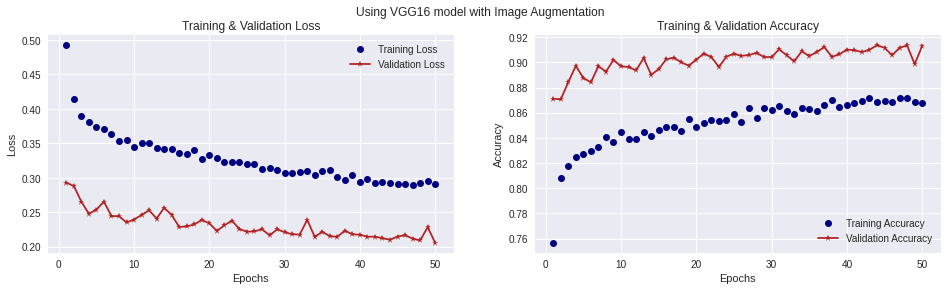

In [ ]:
kru.show_plots(hist.history, plot_title='Using VGG16 model with Image Augmentation')

In [ ]:
# 성능 평가
loss, acc = model_xfer.evaluate_generator(train_generator, steps=train_steps, verbose=1)
print('Training data  -> loss: %.3f, acc: %.3f' % (loss, acc))
loss, acc = model_xfer.evaluate_generator(eval_generator, steps=val_steps, verbose=1)
print('Cross-val data -> loss: %.3f, acc: %.3f' % (loss, acc))
loss, acc = model_xfer.evaluate_generator(test_generator, steps=test_steps, verbose=1)
print('Testing data   -> loss: %.3f, acc: %.3f' % (loss, acc))

312/312 [==============================] - 77s 246ms/step - loss: 0.2460 - acc: 0.8921
Training data  -> loss: 0.246, acc: 0.892
156/156 [==============================] - 16s 103ms/step - loss: 0.2058 - acc: 0.9129
Cross-val data -> loss: 0.206, acc: 0.913
62/62 [==============================] - 6s 103ms/step - loss: 0.1978 - acc: 0.9209
Testing data   -> loss: 0.198, acc: 0.921


In [ ]:
# 구글 드라이브에 저장
kru.save_keras_model(model_xfer, 'kr_cats_vs_dogs_pretrained_vgg16', MODEL_SAVE_DIR)
# model_xfer.save('/content/drive/My Drive/Colab Notebooks/model_states/cat_vs_dog_pretrained_vgg16.h5')
del model_xfer

Saved model to files /content/drive/My Drive/Colab Notebooks/model_states/kr_cats_vs_dogs_pretrained_vgg16.json and /content/drive/My Drive/Colab Notebooks/model_states/kr_cats_vs_dogs_pretrained_vgg16.h5


### 테스트

In [ ]:
cat_test_files = np.array(os.listdir(test_root_cat))
dog_test_files = np.array(os.listdir(test_root_dog))
# for _ in range(5): indexes = np.random.permutation(range(len(cat_test_files)))
# cat_test_files = cat_test_files[indexes]
# dog_test_files = dog_test_files[indexes]
for _ in range(5):
    np.random.shuffle(cat_test_files)
    np.random.shuffle(dog_test_files)
 
test_image_files = []
for image in cat_test_files:
    test_image_files.append(os.path.join(test_root_cat, image))
for image in dog_test_files:
    test_image_files.append(os.path.join(test_root_dog, image))
test_image_files = np.array(test_image_files)
for _ in range(5): indexes = np.random.permutation(range(len(test_image_files)))
test_image_files = test_image_files[indexes]
test_image_files[:10]

array(['/tmp/test/dog/dog.812.jpg', '/tmp/test/cat/cat.864.jpg',
       '/tmp/test/dog/dog.551.jpg', '/tmp/test/dog/dog.746.jpg',
       '/tmp/test/dog/dog.97.jpg', '/tmp/test/cat/cat.940.jpg',
       '/tmp/test/dog/dog.68.jpg', '/tmp/test/cat/cat.341.jpg',
       '/tmp/test/dog/dog.876.jpg', '/tmp/test/cat/cat.532.jpg'],
      dtype='<U26')

In [ ]:
import numpy as np
from keras.preprocessing import image
from tqdm import tqdm
predictions = []   # list of tuples (image_path, probab, pred_name, act_name)
incorrect_predictions = []  # list of tuples (image_path, probab, actual, prediction)
 
for test_image in tqdm(test_image_files):
    img = image.load_img(test_image, target_size=(IMAGE_HEIGHT, IMAGE_WIDTH))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x /= 255.0
 
    images_list = np.vstack([x])
    classes = model_xfer.predict(images_list, batch_size=10)
    prob = classes[0]
    actual_name = (test_image.split(os.path.sep)[-1].split('.')[0]).upper() # == 'CAT' or 'DOG'
    pred_name = 'DOG' if (prob >= 0.5) else 'CAT'
    is_correct = (actual_name == pred_name)
    
    predictions.append((test_image, prob, pred_name, actual_name))
    if not is_correct:
        incorrect_predictions.append((test_image, prob, pred_name, actual_name))
    
    
print("Displaying %d incorrect predictions..." % len(incorrect_predictions))    
for item in incorrect_predictions:
    test_image, prob, pred_name, actual_name = item
    print('%*s - probability: %.4f - predicted %s, is a %s' %
            (50, test_image, prob, pred_name, actual_name))
 
# print("Displaying first 50 predictions...")    
# for item in predictions[:50]:
#     test_image, prob, pred_name, actual_name = item
#     oops = ' -- Oops!' if pred_name != actual_name else ''
#     print('%*s - Prediction (%.4f): is a DOG %s' % (50, test_image, classes[0], oops))
    
#     if pred >= 0.5:
#         print('%*s - Prediction (%.4f): is a DOG %s' % (50, test_image, classes[0], oops))
#     else:
#         print('%*s - Prediction (%.4f): is a CAT %s' % (50, test_image, classes[0], oops))

100%|██████████| 2000/2000 [01:22<00:00, 24.33it/s]

Displaying 159 incorrect predictions...
                         /tmp/test/cat/cat.940.jpg - probability: 0.7232 - predicted DOG, is a CAT
                         /tmp/test/cat/cat.502.jpg - probability: 0.8414 - predicted DOG, is a CAT
                         /tmp/test/dog/dog.700.jpg - probability: 0.2741 - predicted CAT, is a DOG
                         /tmp/test/cat/cat.988.jpg - probability: 0.6337 - predicted DOG, is a CAT
                         /tmp/test/dog/dog.987.jpg - probability: 0.2762 - predicted CAT, is a DOG
                         /tmp/test/dog/dog.774.jpg - probability: 0.4970 - predicted CAT, is a DOG
                         /tmp/test/cat/cat.665.jpg - probability: 0.9593 - predicted DOG, is a CAT
                         /tmp/test/cat/cat.876.jpg - probability: 0.7410 - predicted DOG, is a CAT
                         /tmp/test/cat/cat.407.jpg - probability: 0.7458 - predicted DOG, is a CAT
                         /tmp/test/cat/cat.995.jpg - probability: 0.8

## 새로운 이미지 파일 업로드 및 테스트

In [ ]:
#업로드 위치 : /content/
from google.colab import files
src = list(files.upload().values())[0]

Saving 01test.jpg to 01test.jpg


In [ ]:
#위의 모델 중 성능이 가장 좋은 모델을 불러옴.
model = kru.load_keras_model('kr_cats_vs_dogs_pretrained_vgg16_ft',MODEL_SAVE_DIR)
print(model.summary())

Loaded model from files /content/drive/My Drive/Colab Notebooks/model_states/kr_cats_vs_dogs_pretrained_vgg16_ft.json and /content/drive/My Drive/Colab Notebooks/model_states/kr_cats_vs_dogs_pretrained_vgg16_ft.h5
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_2 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 8192)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 1024)              8389632   
_________________________________________________________________
dropout_7 (Dropout)          (None, 1024)              0         
______________________________________

In [ ]:
#분류 작업
classes = { 
    0.0:'its a cat',
    1.0:'its a dog',
}
def classify(file_path):
    global label_packed
    image = Image.open(file_path)
    # image = image.load_img(image, target_size=(IMG, IMG))
    image = image.resize((IMG,IMG))
    # image = image.img_to_array(img)
    image = numpy.expand_dims(image, axis=0)
    image = numpy.array(image)
    image = image/255
    pred = model.predict([image])[0]
    if pred >= 0.5: sign = classes[1.0]
    else: sign = classes[0.0]
    # sign = pred[0]
    print(sign)

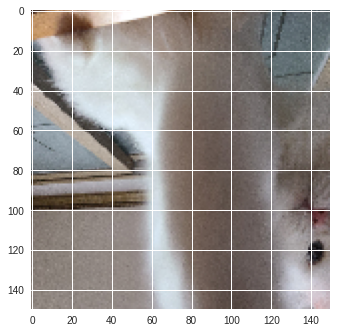

In [ ]:
#결과 
import numpy as np
from keras.preprocessing import image
import matplotlib.pyplot as plt

# test_image, prob, pred_name, actual_name = entry

img = image.load_img('01test.jpg', target_size=(IMAGE_HEIGHT, IMAGE_WIDTH))
img_arr = image.img_to_array(img)
img_arr = np.expand_dims(img_arr, axis=0)
img_arr /= 255.
plt.imshow(img_arr[0])
#plt.title('%s -> Prediction: %s (%.4f)' % (actual_name, pred_name, prob))
plt.show()

In [ ]:
classify('01test.jpg')

its a cat
